# Peak Sets and Genes

Using the links found using Cicero, look within peak sets to see if links are more likely within peak sets. Also try to link peaks/peak sets to genes.

In [2116]:
library(cicero)
library(Matrix)
library(ggplot2)
library(scales)
library(GenomicFeatures)
library(reshape2)
library(rtracklayer)

In [2367]:
gz = "./out/20200417_default_20200220_n74838/coaccess.gt0.1.tsv.gz"
high_conns = read.table(gz, header=F, sep='\t')
colnames(high_conns) = c("Peak1", "Peak2", "coaccess")
high_conns$distance = abs(as.integer(lapply(strsplit(as.character(high_conns$Peak1), "_"), "[[", 2)) - as.integer(lapply(strsplit(as.character(high_conns$Peak2), "_"), "[[", 2)))
min(high_conns$coaccess)
dim(high_conns)
head(high_conns)

[1] 0.1

[1] 3693596       4

,Peak1,Peak2,coaccess,distance
,<fct>,<fct>,<dbl>,<int>
1,chr10_100006055_100006360,chr10_99775825_99776218,0.1803253,230230
2,chr10_100006055_100006360,chr10_99776241_99776466,0.1234813,229814
3,chr10_100006055_100006360,chr10_99779363_99780088,0.3004101,226692
4,chr10_100006055_100006360,chr10_99783995_99784700,0.1134911,222060
5,chr10_100006055_100006360,chr10_99788543_99788788,0.1136927,217512
6,chr10_100006055_100006360,chr10_99788793_99789003,0.1541775,217262


In [1733]:
choose = na.omit(high_conns[(high_conns$coaccess>0.25)&(high_conns$distance<1000), ])
choose = choose[sample(dim(choose)[1]), ]
dim(choose)
head(choose)

[1] 219858      4

,Peak1,Peak2,coaccess,distance
,<fct>,<fct>,<dbl>,<int>
1157043,chr18_27561557_27562162,chr18_27562195_27562396,0.3601625,638
123970,chr10_698762_699055,chr10_699056_699276,0.5384204,294
658843,chr14_25052740_25052941,chr14_25051857_25052058,0.4958961,883
1582010,chr1_244163852_244164072,chr1_244164077_244164642,0.5900232,225
346932,chr11_73158508_73158766,chr11_73158809_73159024,0.5399624,301
3602501,chr9_33414988_33415194,chr9_33414761_33414962,0.5636898,227


## Prepare Promoters

In [2117]:
gencode.basic.hg38 = import.gff(gzfile("../../../resources/GENCODE/gencode.v33.chr_patch_hapl_scaff.basic.annotation.gtf.gz"))
gencode.basic.hg38 = keepStandardChromosomes(gencode.basic.hg38, pruning.mode = "coarse")
gencode.basic.tx.hg38 = subset(subset(gencode.basic.hg38, gene_type=="protein_coding"), type=="transcript")
head(gencode.basic.tx.hg38, 3)
length(gencode.basic.tx.hg38)

Warning message in readGFF(filepath, version = version, filter = filter):
"connection is not positioned at the start of the file, rewinding it"


GRanges object with 3 ranges and 21 metadata columns:
      seqnames        ranges strand |   source       type     score     phase
         <Rle>     <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1]     chr1   65419-71585      + |   HAVANA transcript      <NA>      <NA>
  [2]     chr1   69055-70108      + |  ENSEMBL transcript      <NA>      <NA>
  [3]     chr1 450703-451697      - |   HAVANA transcript      <NA>      <NA>
                gene_id      gene_type   gene_name       level     hgnc_id
            <character>    <character> <character> <character> <character>
  [1] ENSG00000186092.6 protein_coding       OR4F5           2  HGNC:14825
  [2] ENSG00000186092.6 protein_coding       OR4F5           3  HGNC:14825
  [3] ENSG00000284733.1 protein_coding      OR4F29           2  HGNC:31275
               havana_gene     transcript_id transcript_type transcript_name
               <character>       <character>     <character>     <character>
  [1] OTTHUMG00000001094.4 

[1] 58073

In [2118]:
tss.hg38 = unique(resize(gencode.basic.tx.hg38, width=1, fix='start'))
tss.hg38

GRanges object with 51948 ranges and 21 metadata columns:
          seqnames    ranges strand |   source       type     score     phase
             <Rle> <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
      [1]     chr1     65419      + |   HAVANA transcript      <NA>      <NA>
      [2]     chr1     69055      + |  ENSEMBL transcript      <NA>      <NA>
      [3]     chr1    451697      - |   HAVANA transcript      <NA>      <NA>
      [4]     chr1    686673      - |   HAVANA transcript      <NA>      <NA>
      [5]     chr1    925731      + |   HAVANA transcript      <NA>      <NA>
      ...      ...       ...    ... .      ...        ...       ...       ...
  [51944]     chrM     10470      + |  ENSEMBL transcript      <NA>      <NA>
  [51945]     chrM     10760      + |  ENSEMBL transcript      <NA>      <NA>
  [51946]     chrM     12337      + |  ENSEMBL transcript      <NA>      <NA>
  [51947]     chrM     14673      - |  ENSEMBL transcript      <NA>      <NA>
  [519

In [2299]:
# for downstream analyses, allow co-accessibility to tss proximal enhancers
prom.hg38 = promoters(tss.hg38, upstream = 2500, downstream = 2500)
prom.hg38

GRanges object with 51948 ranges and 21 metadata columns:
          seqnames        ranges strand |   source       type     score
             <Rle>     <IRanges>  <Rle> | <factor>   <factor> <numeric>
      [1]     chr1   62919-67918      + |   HAVANA transcript      <NA>
      [2]     chr1   66555-71554      + |  ENSEMBL transcript      <NA>
      [3]     chr1 449198-454197      - |   HAVANA transcript      <NA>
      [4]     chr1 684174-689173      - |   HAVANA transcript      <NA>
      [5]     chr1 923231-928230      + |   HAVANA transcript      <NA>
      ...      ...           ...    ... .      ...        ...       ...
  [51944]     chrM    7970-12969      + |  ENSEMBL transcript      <NA>
  [51945]     chrM    8260-13259      + |  ENSEMBL transcript      <NA>
  [51946]     chrM    9837-14836      + |  ENSEMBL transcript      <NA>
  [51947]     chrM   12174-17173      - |  ENSEMBL transcript      <NA>
  [51948]     chrM   12247-17246      + |  ENSEMBL transcript      <NA>
      

## Visualize

In [2300]:
gene_anno <- data.frame(gencode.basic.hg38)
gene_anno = gene_anno[!is.na(gene_anno$exon_number), ]


# rename some columns to match requirements
gene_anno$chromosome <-  gene_anno$seqnames
gene_anno$gene <- gene_anno$gene_id
gene_anno$transcript <- gene_anno$transcript_name
gene_anno$symbol <- gene_anno$gene_name

In [2208]:
dim(gene_anno)

[1] 1603274      30

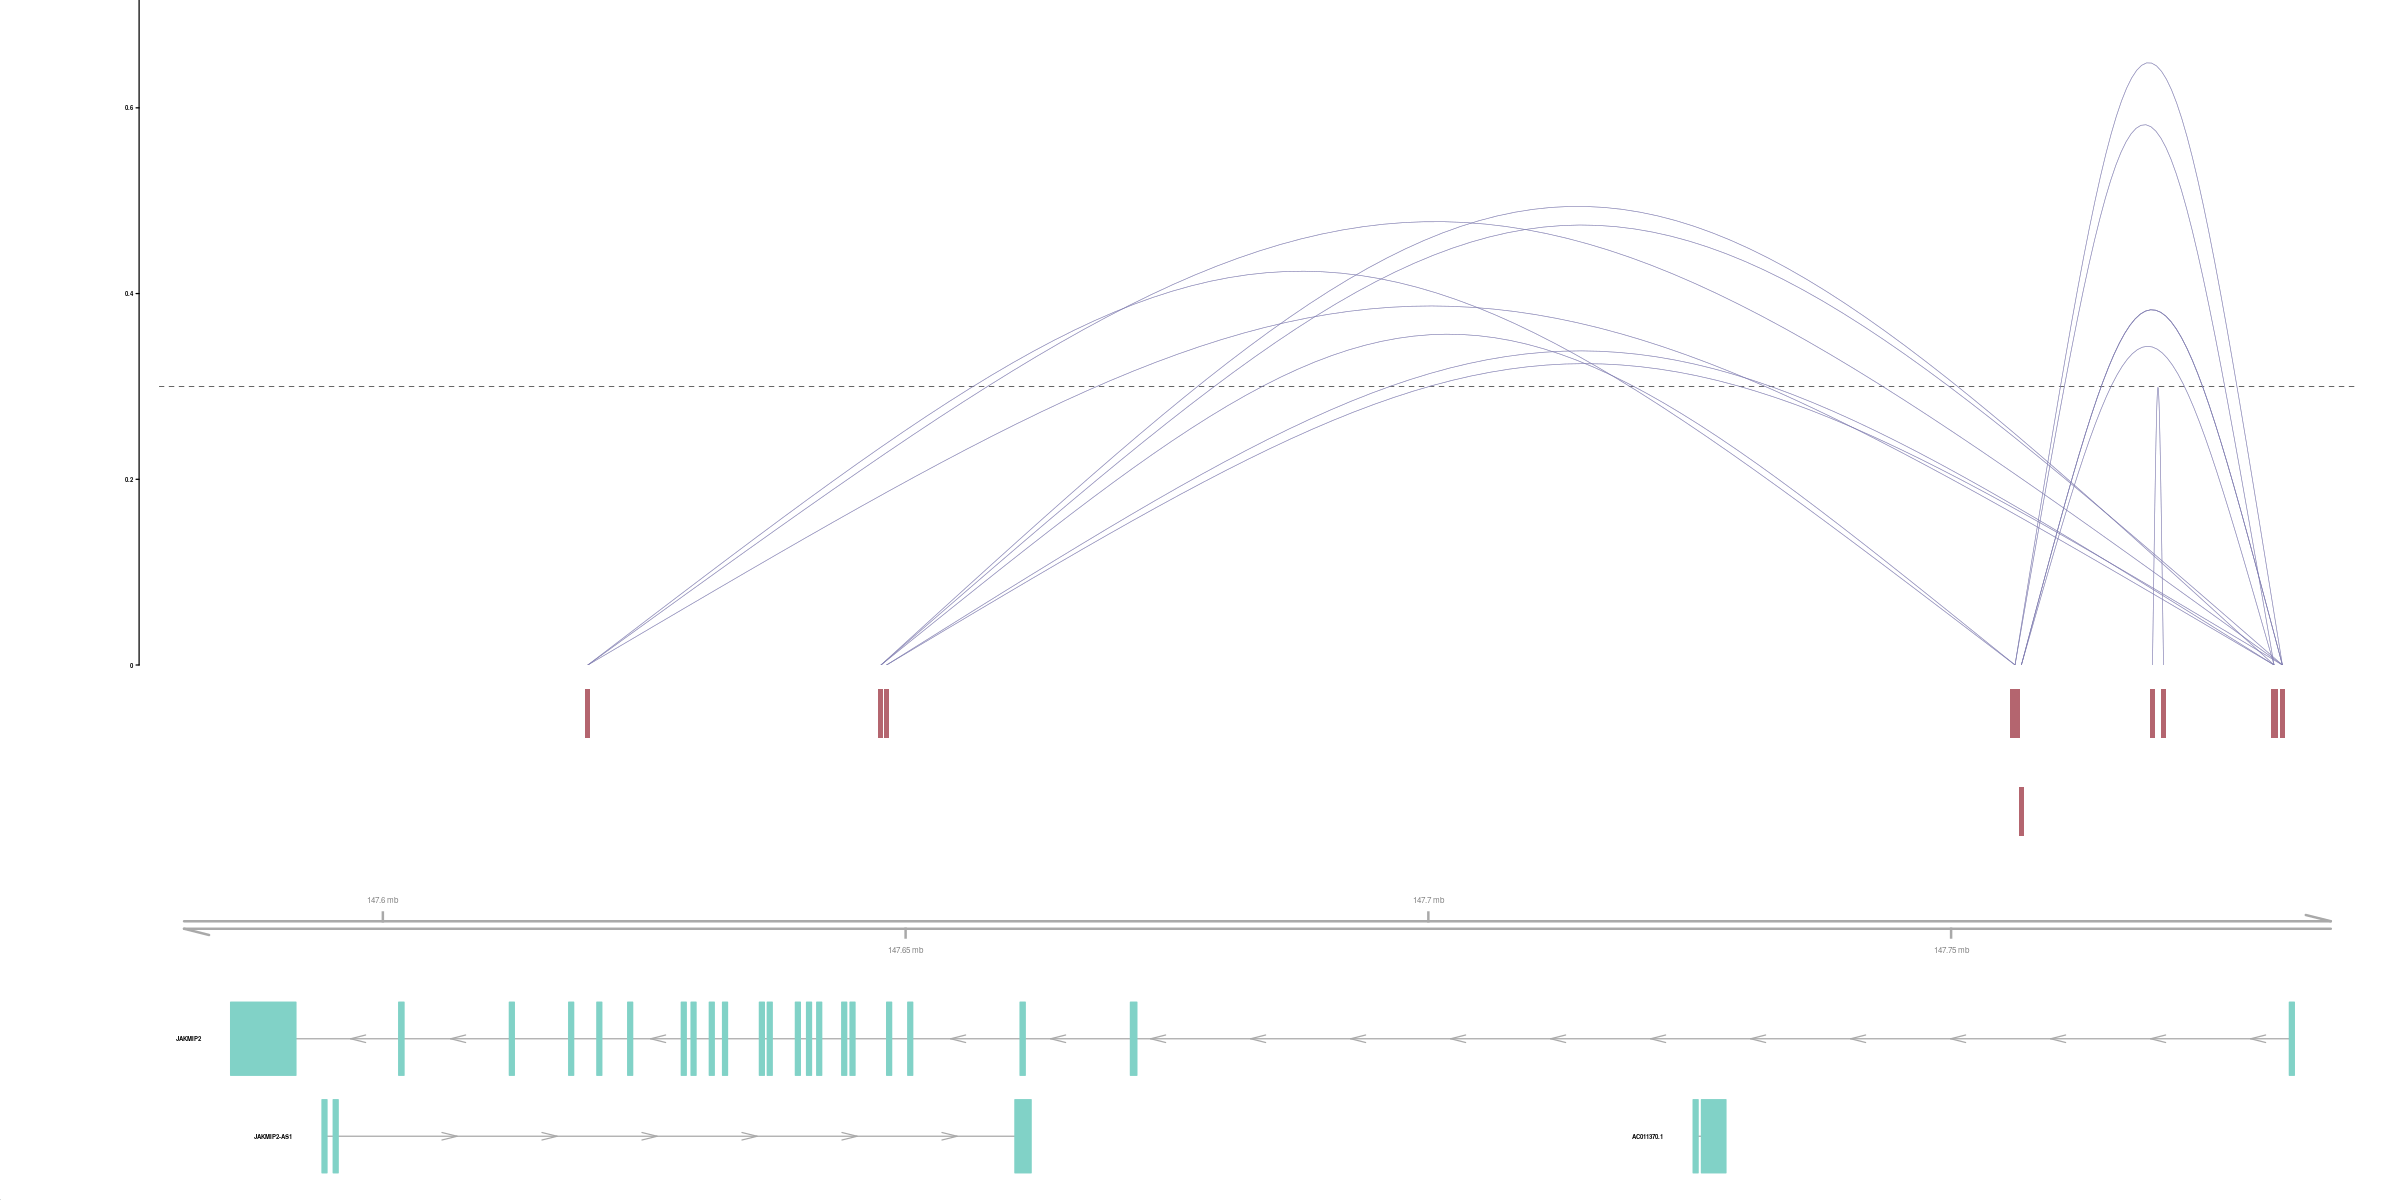

In [2213]:
options(repr.plot.width = 20, repr.plot.height = 10)

plot_connections(high_conns[high_conns$distance>1000,], "chr5", 147578594, 147788708,
#                  viewpoint = "chr2_209425462_209426064",
                 gene_model = gene_anno, 
                 coaccess_cutoff = .3, 
                 connection_width = .5, 
                 collapseTranscripts = "longest" )

## Peak Sets

In [2368]:
peaks_left = sub("_", "-", sub("_", ":", high_conns$Peak1))
peaks_right = sub("_", "-", sub("_", ":", high_conns$Peak2))
head(peaks_left)
head(peaks_right)

[1] "chr10:100006055-100006360" "chr10:100006055-100006360"
[3] "chr10:100006055-100006360" "chr10:100006055-100006360"
[5] "chr10:100006055-100006360" "chr10:100006055-100006360"

[1] "chr10:99775825-99776218" "chr10:99776241-99776466"
[3] "chr10:99779363-99780088" "chr10:99783995-99784700"
[5] "chr10:99788543-99788788" "chr10:99788793-99789003"

In [2369]:
# looks like each connection is entered twice
all(sort(peaks_left)==sort(peaks_right))

[1] TRUE

In [2370]:
peaks_left_is_gene = seq(1,length(peaks_left)) %in% queryHits(findOverlaps(GRanges(peaks_left), prom.hg38))
peaks_right_is_gene = seq(1,length(peaks_right)) %in% queryHits(findOverlaps(GRanges(peaks_right), prom.hg38))
sum(peaks_left_is_gene)
sum(peaks_right_is_gene)

[1] 544458

[1] 544458

In [2521]:
peak_set = read.table("../20200307_fine_clustering/beds/20200330_gridmap_peakwidthnorm_n20/idx19.bed")
# peak_set = rbind(peak_set, read.table("../20200307_fine_clustering/beds/20200330_gridmap_peakwidthnorm_n20/idx2.bed"))
# peak_set = rbind(peak_set, read.table("../20200307_fine_clustering/beds/20200330_gridmap_peakwidthnorm_n20/idx18.bed"))
colnames(peak_set) = c("chr", "start", "end")
peak_set = paste(paste(peak_set$chr, peak_set$start, sep=":"), peak_set$end, sep='-')
head(peak_set)

[1] "chr1:1222306-1222544" "chr1:1261227-1261590" "chr1:1326594-1326812"
[4] "chr1:1557055-1557256" "chr1:1563751-1564023" "chr1:2187640-2187943"

In [2522]:
peaks_left_overlaps_peak_set = seq(1,length(peaks_left)) %in% queryHits(findOverlaps(GRanges(peaks_left), GRanges(peak_set)))
peaks_right_overlaps_peak_set = seq(1,length(peaks_right)) %in% queryHits(findOverlaps(GRanges(peaks_right), GRanges(peak_set)))
sum(peaks_left_overlaps_peak_set)
sum(peaks_right_overlaps_peak_set)

[1] 187694

[1] 187694

In [2523]:
length(peak_set)

[1] 15281

In [2524]:
# find enhancer/non-promoter -> gene links such that enhancer belongs to set
# can look from left to right only since each link is repeated twice 
enhancer_to_gene_link = (peaks_left_overlaps_peak_set&(!peaks_left_is_gene)&(peaks_right_is_gene)) #&(high_conns$distance>10000))
e2g_overlaps = findOverlaps(GRanges(peaks_right[enhancer_to_gene_link]), prom.hg38)
e2g_enhs = peaks_left[enhancer_to_gene_link][queryHits(e2g_overlaps)] # these are the enhancers that link to gene
e2g_genes = prom.hg38[subjectHits(e2g_overlaps)]$gene_name
e2g_transcripts = prom.hg38[subjectHits(e2g_overlaps)]$transcript_name
e2g_uniq = unique(data.frame(e=e2g_enhs, g=e2g_genes)) # uniquify e-g link
e2gt_uniq = unique(data.frame(e=e2g_enhs, gtx=e2g_transcripts)) # uniquify e-g:tx link

sum(enhancer_to_gene_link)
length(unique(e2g_uniq$g))
length(unique(e2gt_uniq$gtx))

[1] 7929

[1] 2138

[1] 4485

In [2525]:
rev(sort(table(e2g_uniq$g)))[1:50]
rev(sort(table(e2gt_uniq$gtx)))[1:50]
# rev(sort(table(e2g_genes)))[200]


  CLDN20    LPAR1     ANO4      MCC    NUP93    NLRC5    TIAM2 PSME3IP1 
      23       19       18       17       16       16       15       15 
     DST    BMPER     AGMO   MAP4K3     LMO7 ARHGAP22    TRIM2    RIPK1 
      15       15       15       14       14       14       13       13 
     MT3    MED23   ERVW-1    ENPP3    CDKL4    TRABD   PNPLA1      MET 
      13       13       13       13       13       12       12       12 
  DNAJB8   COL3A1    ATP9A   ZBTB20      VIT TMEM200A    PARP1     NSG1 
      12       12       12       11       11       11       11       11 
   MYLK4    MKLN1    KLF12   HDAC10     FEZ2   ARID1B    AEBP2     UTRN 
      11       11       11       11       11       11       11       10 
    UMPS     TMX1  TMEM248  TMEM123    SMLR1   MYBPC1    MTCL1    ITGB4 
      10       10       10       10       10       10       10       10 
   GFOD1  EPB41L2 
      10       10 


  CLDN20-201    LPAR1-202     ANO4-209    NUP93-210    NUP93-202    NLRC5-201 
          23           19           18           16           16           16 
PSME3IP1-220      MCC-208      MCC-201      DST-220      DST-205      DST-201 
          15           15           15           15           15           15 
   BMPER-228    BMPER-217    BMPER-216    BMPER-214    BMPER-201     AGMO-201 
          15           15           15           15           15           15 
   TIAM2-201      MCC-209   MAP4K3-205 ARHGAP22-206    RIPK1-202      MT3-206 
          14           14           14           14           13           13 
     MT3-202      MT3-201    MED23-209    MED23-205    MED23-204    MED23-203 
          13           13           13           13           13           13 
   MED23-202    MED23-201   ERVW-1-202    ENPP3-203    CDKL4-201    TRIM2-207 
          13           13           13           13           13           12 
   TRABD-204    TRABD-203   PNPLA1-201      MET-202

In [2411]:
e2g_uniq[grepl("PLEKHG1", e2g_uniq$g),]

,e,g
,<fct>,<fct>
2324,chr6:150841981-150842448,PLEKHG1
2326,chr6:150842475-150842871,PLEKHG1
2328,chr6:150926433-150926823,PLEKHG1
2329,chr6:150954745-150955309,PLEKHG1
2330,chr6:150987879-150988080,PLEKHG1


In [2557]:
Q = "MT1G"
Q %in% unique(e2g_uniq$g)
table(e2g_uniq$g)[Q]

[1] TRUE

MT1G 
   3

In [2413]:
# high_conns[enhancer_to_gene_link,][unique(queryHits(findOverlaps(GRanges(peaks_right[enhancer_to_gene_link]), prom.hg38[prom.hg38$gene_id=="MYCN"]))),]

In [2532]:
# all peaks that are coaccessible with this set of peaks
links_part_of = peaks_left_overlaps_peak_set # don't need right as each link appears twice
peaks_touched = unique(c(peaks_left[links_part_of], peaks_right[links_part_of], peak_set))

In [2533]:
length(peaks_touched)
head(peaks_touched)

[1] 76953

[1] "chr10:100038048-100038259" "chr10:100038266-100038787"
[3] "chr10:100503198-100503471" "chr10:100509498-100509759"
[5] "chr10:1007651-1007877"     "chr10:101160643-101160965"

In [2534]:
# all genes touch
genes_touched = unique(prom.hg38[unique(queryHits(findOverlaps(prom.hg38, GRanges(peaks_touched))))]$gene_name)
length(genes_touched)

[1] 2360

In [2535]:
"JAKMIP2" %in% genes_touched

[1] TRUE

In [2536]:
# genes_touched

In [2537]:
# set of genes that simply intersects with peak set
genes_in_peak_set = unique(prom.hg38[unique(queryHits(findOverlaps(prom.hg38, GRanges(peak_set))))]$gene_name)
length(genes_in_peak_set)

[1] 565

In [2538]:
'MCC' %in% genes_in_peak_set

[1] TRUE

In [2539]:
length(intersect(genes_touched, names(table(e2g_uniq$g))))
length(intersect(names(table(e2g_uniq$g)), genes_in_peak_set))
length(intersect(genes_touched, genes_in_peak_set))

[1] 2138

[1] 400

[1] 565

In [2540]:
length(setdiff(genes_touched, genes_in_peak_set))

[1] 1795

In [1777]:
TMP_PATH = "tmp_c1.txt"
genes_to_write = names(rev(sort(table(e2g_uniq$g))))

fileConn = file(TMP_PATH)
writeLines(unique(genes_to_write), fileConn)
close(fileConn)

In [2541]:
TMP_PATH = "tmp_ordered.txt"
genes_to_write = unique(c(names(rev(sort(table(e2g_uniq$g)))), genes_touched))

fileConn = file(TMP_PATH)
writeLines(unique(c(genes_to_write, sample(unique(prom.hg38$gene_name)))), fileConn)
close(fileConn)

In [ ]:
TMP_PATH = "tmp_all.txt"
fileConn = file(TMP_PATH)
writeLines(unique(prom.hg38$gene_id), fileConn)
close(fileConn)

## mRNA analysis

From Cachiarelli et al 2015

In [934]:
# load bulk RNA-seq data
fpkm = read.table("/users/surag/kundajelab/scATAC-reprog/resources/GSE62777/RNAseq.FPKM.tsv", sep='\t', header=T)
fpkm$gene_id = NULL
fpkm$locus=NULL
tpm = fpkm
tpm[,2:ncol(tpm)] = 1e6*t(t(tpm[,2:ncol(tpm)])/colSums(tpm[,2:ncol(tpm)]))

# removing genes with dup names
tpm = tpm[!duplicated(tpm$gene_short_name),]
rownames(tpm) = tpm$gene_short_name
tpm$gene_short_name = NULL

tpm["GAPDH",]

,hiF.T_P14,X2dd_DOX_plus,X5dd_DOX_plus,X8dd_DOX_plus,X10dd_DOX_plus_SSEA3_pos,X14dd_DOX_plus_SSEA3_pos,X20dd_DOX_plus_TRA_plus,X24dd_TRA_pos_DOX_plus,X24dd_TRA_pos_DOX_minus,hIPSC.T_P10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GAPDH,7803.64,4963.505,3908.693,3839.776,3795.548,3364.503,3032.412,3790.955,5598.224,4731.256


In [2552]:
# gene_set_to_plot = names(rev(sort(table(e2g_uniq$g))))
gene_set_to_plot = names(rev(sort(table(e2g_uniq$g)[table(e2g_uniq$g)>=5])))
# gene_set_to_plot = genes_touched
# gene_set_to_plot = genes_in_peak_set
# gene_set_to_plot = setdiff(genes_touched, genes_in_peak_set)

In [2553]:
colMedians(as.matrix(log2(1+tpm)[rownames(tpm) %in% gene_set_to_plot, ]))

[1] 3.495293 4.106485 4.243060 4.386301 4.108799 3.866451 3.219769 3.236131
 [9] 3.249761 3.168387

[1] 349

Warning message:
"Removed 40 rows containing non-finite values (stat_boxplot)."


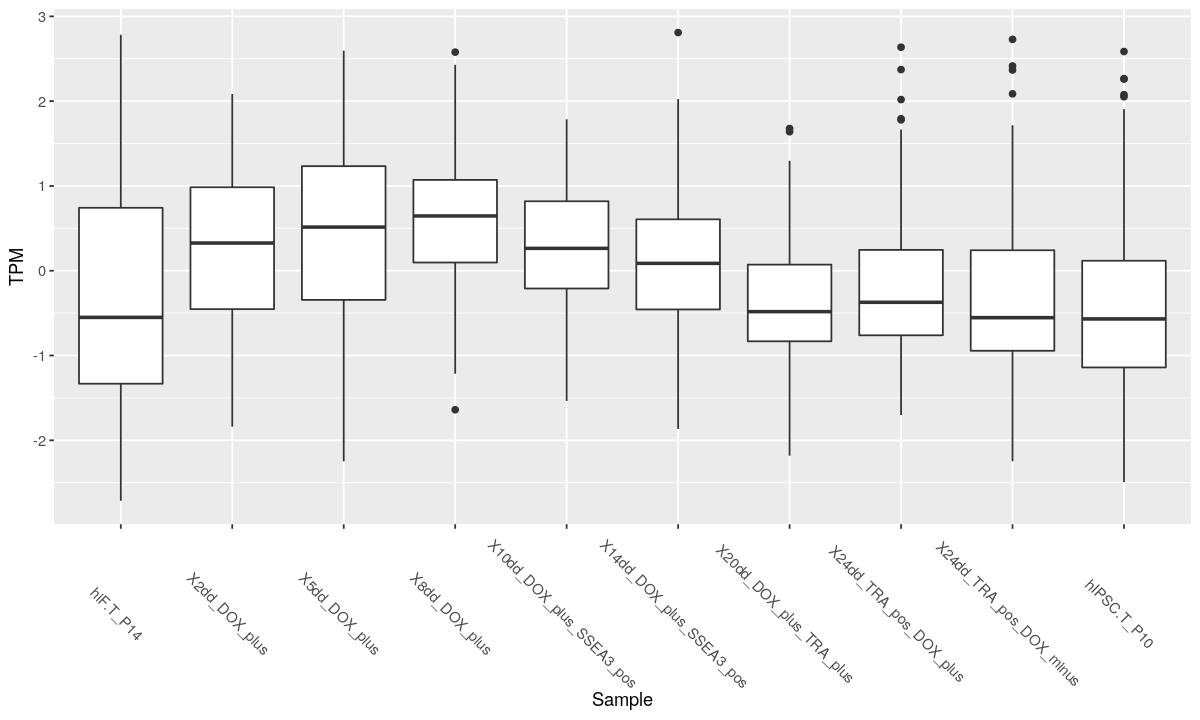

In [2554]:
options(repr.plot.width = 10, repr.plot.height = 6)

sum(gene_set_to_plot %in% rownames(tpm))

# ggplot(melt(log2(1+tpm)[rownames(tpm) %in% gene_set_to_plot, ]), aes(x=variable, y=value)) +
ggplot(melt(t(scale(t(log2(1+tpm)[rownames(tpm) %in% gene_set_to_plot, ])))), aes(x=Var2, y=value)) +
stat_boxplot() +
# geom_line(aes(group=Var1),size=0.1) + geom_point() +
theme(axis.text.x = element_text(angle = -45)) +
ylab("TPM") + xlab("Sample")
# geom_boxplot(outlier.shape = NA) + geom_jitter(width = 0.2)
# coord_cartesian(ylim=c(0,8)) 

In [2555]:
filtered_gene_set = names(rev(sort(table(e2g_uniq$g)[table(e2g_uniq$g)>=1])))

# peak is early
filtered_gene_set = filtered_gene_set[rowMaxs(as.matrix(tpm[filtered_gene_set,]))==rowMaxs(as.matrix(tpm[filtered_gene_set,c("X2dd_DOX_plus", "X5dd_DOX_plus", "X8dd_DOX_plus")]))]

# low expr in Fib and ESC
# filtered_gene_set = filtered_gene_set[(tpm[filtered_gene_set,1]<1)&(tpm[filtered_gene_set,10]<1)]

filtered_gene_set = filtered_gene_set[!is.na(filtered_gene_set)]

for (x in filtered_gene_set) {
    cat(sprintf("%s\n", x))
}

CLDN20
ANO4
MCC
NUP93
NLRC5
TIAM2
DST
AGMO
MAP4K3
MT3
MED23
ERVW-1
ENPP3
TRABD
PNPLA1
MET
DNAJB8
COL3A1
ATP9A
NSG1
MYLK4
MKLN1
FEZ2
ARID1B
UTRN
UMPS
TMX1
TMEM123
MYBPC1
GFOD1
DDX60
BZW2
ANKMY2
AMFR
AC005154.5
TSKU
TMC1
TM2D1
SULF1
PLEKHG1
MKKS
LRRC69
JAG1
IFRD1
HPSE
FBXW11
EXPH5
DNAJC11
CDH6
ATXN1
AQP1
WNT11
SLC26A7
SH3BP5
SERPINB1
SEMA3E
SCARA5
RAPGEF4
PPP3CA
LAMC1
IGF2
GYPC
DOK6
CLU
CHST13
ARHGAP18
ALDH1A2
ZNF326
ZNF148
WRNIP1
VPS8
UGT8
TMTC3
SYNE1
SUB1
SLC9B1
SERPINB6
RBMS1
PTRH2
PRTFDC1
PLCL2
PER2
PAPLN
NDUFV2
NCF2
LRIG1
LLPH
LGALSL
HUS1B
DIS3L2
DAZL
CEP290
CCT5
CARD16
BMPR1B
APBA1
ZFAT
USP24
TSEN15
TRIM9
TMEM14A
TM9SF3
STX18
STAT3
SLC3A1
SLC22A23
SLC22A13
PTHLH
PSMB2
PLAGL1
PID1
PDGFRA
NKAIN2
NFE2L2
LUC7L2
LSAMP
KRIT1
ITGAV
HS3ST5
HOXA2
HMGN4
GSN
COL4A4
COL4A3
COBLL1
CEP112
CD302
C9orf135
BLID
ARHGEF7
APOL1
ANKIB1
ANK2
VSIG8
TSPAN3
TNS3
TNNC1
TNFAIP6
TMEM174
TMEM171
TMC6
TBC1D22A
ST7
SLURP1
SAP30L
SAP30
RAET1L
PRR15
PRKG1
PRDM1
PPARGC1B
PIGM
OXR1
NISCH
NFIB
NEIL3
NBPF1
MYCT1
MEF2C

## Misc Analysis of Whether Peak at TSS Implies Expression and so on

In [2097]:
peak_set = read.table(gzfile("/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bulk/croo/iPSC/peak/overlap_reproducibility/overlap.optimal_peak.narrowPeak.gz"))
colnames(peak_set) = c("chr", "start", "end")
peak_set = paste(paste(peak_set$chr, peak_set$start, sep=":"), peak_set$end, sep='-')
head(peak_set)

[1] "chr1:100034561-100034806" "chr1:100037558-100039065"
[3] "chr1:100037558-100039065" "chr1:100037558-100039065"
[5] "chr1:100037558-100039065" "chr1:100037558-100039065"

In [2107]:
gene_overlap_tss = unique(tss.hg38[queryHits(findOverlaps(tss.hg38, GRanges(peak_set)))]$gene_id)
gene_overlap_prom = unique(tss.hg38[queryHits(findOverlaps(promoters(tss.hg38, upstream=2000, downstream=500), GRanges(peak_set)))]$gene_id)

In [2110]:
gene_not_overlap_tss = setdiff(tss.hg38$gene_id, gene_overlap_tss)
gene_not_overlap_prom = setdiff(tss.hg38$gene_id, gene_overlap_prom)
gene_overlap_prom_not_tss = setdiff(gene_overlap_prom, gene_overlap_tss)

In [2111]:
gene_overlap_tss_in_rna = gene_overlap_tss[gene_overlap_tss %in% rownames(tpm)]
gene_overlap_prom_in_rna = gene_overlap_prom[gene_overlap_prom %in% rownames(tpm)]

gene_not_overlap_tss_in_rna = gene_not_overlap_tss[gene_not_overlap_tss %in% rownames(tpm)]
gene_not_overlap_prom_in_rna = gene_not_overlap_prom[gene_not_overlap_prom %in% rownames(tpm)]

gene_overlap_prom_not_tss_in_rna = gene_overlap_prom_not_tss[gene_overlap_prom_not_tss %in% rownames(tpm)]

length(gene_overlap_tss_in_rna)
length(gene_overlap_prom_in_rna)
length(gene_not_overlap_tss_in_rna)
length(gene_not_overlap_prom_in_rna)
length(gene_overlap_prom_not_tss_in_rna)

[1] 14275

[1] 15447

[1] 5452

[1] 4280

[1] 1172

In [2114]:
sum(tpm[gene_overlap_tss_in_rna, 10]>1)
sum(tpm[gene_overlap_prom_in_rna, 10]>1)
sum(tpm[gene_not_overlap_tss_in_rna, 10]>1)
sum(tpm[gene_not_overlap_prom_in_rna, 10]>1)
sum(tpm[gene_overlap_prom_not_tss_in_rna, 10]>1)

[1] 11576

[1] 11800

[1] 582

[1] 358

[1] 224